In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
import scipy.sparse.linalg as sa
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import util

def load_data(size='small', test_size=0.3):
    ratings = util.read_files(size=size)[0]
    movie_counts = ratings.groupby('movieId').count()
    good_movies = set(movie_counts[movie_counts['userId'] > 20].index)
    # print(len(good_movies))
    ratings = ratings[ratings.movieId.isin(good_movies)]
    indices = np.unique(ratings['movieId'].values, return_inverse=True)[1]
    ratings['movieId'] = indices.astype('int32')
    return train_test_split(ratings, test_size=test_size)

train, test = load_data(size='small', test_size=0.1)

# Item-item collaborative filtering
First precompute similarity matrix between all items
using cosine distance between rows of utility (`item x user`) matrix

Then predict unknown score for given `user` and `movie` by taking
weighted average of all ratings of this user

In [3]:
def calculate_item_item_similarity(ratings):
    """
    Calculate matrix of cosine distances between movies
    treated as vectors of ratings 
    """
    # Calculate the dot-products of ratings for all movies
    # Use sparse matrix for calculation to accomodate large data-set (~260k users, ~53k movies)
    # Storing results as dense matrix, allows us to use in-place operations
    # and provides faster indexing
    ii_similarity = coo_matrix(
        (ratings['rating'], (ratings['movieId'], ratings['userId']))
        ).tocsr()
    ii_similarity = ii_similarity.dot(ii_similarity.transpose()).toarray()
    
    d = 1 / np.sqrt(ii_similarity.diagonal())
    ii_similarity *= d.reshape((-1, 1))
    ii_similarity *= d.reshape((1, -1))
    return ii_similarity

In [9]:
ii_similarity = calculate_item_item_similarity(train)
user_ratings = train.groupby('userId').indices

def predict(user, movie, ratings=train):
    """
    Predict rating of movie by user by calculating weighted average
    of ratings given by this user to other movies
    """
    other = ratings.iloc[user_ratings[user]]
    similarities = ii_similarity[movie, other['movieId']]
    tmp = similarities * other['rating']
    tmp = np.sum(tmp) / similarities.sum()
    return tmp

def predict_knn(user, movie, k=6, ratings=train):
    """
    Predict rating of movie by user by calculating average
    of ratings given by this user to k most similar movies
    """
    other = ratings.iloc[user_ratings[user]].copy()
    other['sim'] = ii_similarity[movie, other['movieId']]
    k = min(k, len(other.index))
    tmp = other.sort_values(by='sim', ascending=False).head(k)['rating'].mean()
    return tmp

Asses rating prediction by calculating RMSE (Root Mean Square Error)

In [10]:
s = 0
num_samples = min(len(test.index), 10000)
for r in test.head(num_samples).itertuples():
    p = predict(r.userId, r.movieId)
    s += np.float64((p - r.rating) ** 2)
s /= num_samples
s = np.sqrt(s)
print(f'Error: {s}')

Error: 0.8937604236571683


In [11]:
acc = []

for k in range(1, 21):
    s = 0
    num_samples = min(len(test.index), 10000)
    for r in test.head(num_samples).itertuples():
        p = predict_knn(r.userId, r.movieId, k=k)
        s += np.float64((p - r.rating) ** 2)
    s /= num_samples
    s = np.sqrt(s)
    print(f'Error for k={k}\tis {s}')
    acc.append({ 'k': k, 'err': s })

Error for k=1	is 1.078107708730052
Error for k=2	is 0.9480930930300595
Error for k=3	is 0.8977550060804372
Error for k=4	is 0.8779007465398575
Error for k=5	is 0.8676700912240554
Error for k=6	is 0.8626511265096257
Error for k=7	is 0.857159932524491
Error for k=8	is 0.8551119541479916
Error for k=9	is 0.8516080332668553
Error for k=10	is 0.8473134352389822
Error for k=11	is 0.8487484044962831
Error for k=12	is 0.8480272098455146
Error for k=13	is 0.8462470512677099
Error for k=14	is 0.8473062590018429
Error for k=15	is 0.8472665335129794
Error for k=16	is 0.8470155478808818
Error for k=17	is 0.8468551247177545
Error for k=18	is 0.8460313625713736
Error for k=19	is 0.8459433312714392
Error for k=20	is 0.8457124865065456


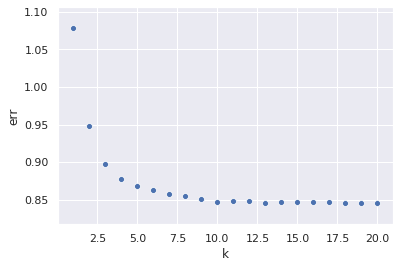

In [12]:
sns.scatterplot(data=pd.DataFrame(acc), x='k', y='err')

# Singular Value Decomposition
Another approach to predicting recommendations is to factorize the utility
matrix using SVD. This allows us to extract latent features (either for users or movies)
and reduce the dimensionality of the problem

In [13]:
ratings, test = load_data(size='small', test_size=0.1)
user_mean = ratings.groupby('userId')['rating'].mean()
means = user_mean.loc[ratings['userId'].array].values
print(means.size)
print(ratings['rating'].values)
print(ratings['rating'].values - means)
ratings['rating'] = ratings['rating'] - means
utility = coo_matrix(
        (ratings['rating'], (ratings['userId'], ratings['movieId']))
        ).tocsr()

59992
[4.  3.5 3.5 ... 5.  4.5 4.5]
[-0.2578 -0.1074 -0.293  ...  0.1406  0.2188  0.4688]


In [14]:
def predict(user, movie):
    return user_mean[user] + u[user, :] @ vt[:, movie]
acc = []
for k in [4, 5, 6, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    u, s, vt = sa.svds(utility, k=k)
    u = u @ np.diag(s)

    s = 0
    num_samples = min(len(test.index), 10000)
    for r in test.head(num_samples).itertuples():
        p = predict(r.userId, r.movieId)
        s += np.float64((p - r.rating) ** 2)
    s /= num_samples
    s = np.sqrt(s)
    acc.append({ 'k': k, 'err': s })
    print(f'Error for k={k}\t is {s}')
acc = pd.DataFrame(acc)

Error for k=4	 is 0.8803772105168824
Error for k=5	 is 0.8770404378241051
Error for k=6	 is 0.8734747783570753
Error for k=10	 is 0.8737527423471138
Error for k=15	 is 0.8786803483067996
Error for k=20	 is 0.8828963393159125
Error for k=30	 is 0.8894129411688102
Error for k=40	 is 0.8940406781323801
Error for k=50	 is 0.89842171901862
Error for k=60	 is 0.9027309712423669
Error for k=70	 is 0.9060919778405411
Error for k=80	 is 0.9079378823494456
Error for k=90	 is 0.9097734794921262
Error for k=100	 is 0.912475971994917


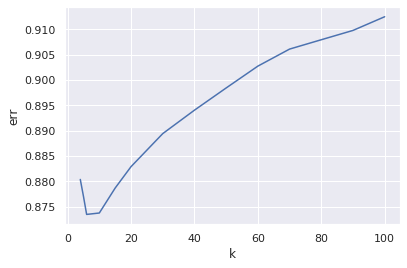

In [15]:
sns.lineplot(data=acc, x='k', y='err')